# MNIST-Fashion

In [24]:
#benötigte imports
import tensorflow as tf
import numpy as np
import os
from tensorflow.python.eager import context
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import plot_model

# Mulitthreading Einstellungen

In [25]:
# parallelization Einstellungen
_ = tf.Variable([1])
context._context = None
context._create_context()
num_threads = os.cpu_count()
tf.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)

# Daten Laden

In [26]:
def load_mnist(kind='train', model_type ='convolutional'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(os.getcwd(),
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(os.getcwd(),
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
    if model_type == 'convolutional':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                                offset=16).reshape(len(labels), 28, 28)#.reshape(len(labels), 784)
    elif model_type == 'fully_connected':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [27]:
#x_train_conv, y_train_conv = load_mnist(kind='train', model_type ='convolutional')
#x_test_conv, y_test_conv = load_mnist(kind='t10k', model_type ='convolutional')
#x_train_conv = np.expand_dims(x_train_conv, -1)
#x_test_conv = np.expand_dims(x_test_conv, -1)

In [28]:
(x_train, y_train_conv), (x_test, y_test_conv) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train_conv = np.expand_dims(x_train, -1)
x_test_conv = np.expand_dims(x_test, -1)

# Funktion zum Trainieren des Netzwerks, mit Rückgabe der Testgenauigkeit nach jedem Step

In [29]:
from keras.callbacks import Callback

# erstelle Klasse mit benutzerdefinierten Aktionen, die während des trainings ausgeführt werden sollen
class TrainMetricsCallback(Callback):
    def __init__(self, x_test=None, y_test=None):
        super(TrainMetricsCallback, self).__init__()
        # listen zum speichern der accuracy und losses auf dem Test und dem Trainingsdatenset nach jeder epoch
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        self.x_test = x_test
        self.y_test = y_test

    # Am ende der epoch füge die accuracy und loss werte zu den Listen hinzu
    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))

        if self.x_test is not None and self.y_test is not None:
            # Auswerten der modells für das Trainigsdatenset
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            self.test_losses.append(loss)
            self.test_accuracies.append(accuracy)
# Methode um nach jdem Trainingsschritt die accuracy und loss sowohl auf dem Testdatenset als auch
# auf den Trainingsdatenset als Liste zurückzugeben
def train_and_get_metrics(model, x_train, y_train, x_test=None, y_test=None, epochs=1, batch_size = 128):
    train_metrics_callback = TrainMetricsCallback(x_test, y_test)
    model.fit(x_train, y_train, epochs=epochs, callbacks=[train_metrics_callback],  batch_size=batch_size)

    # geben die accuracies und losses für die Test und Trainingsdaten zurück
    return train_metrics_callback.train_losses, train_metrics_callback.train_accuracies, \
           train_metrics_callback.test_losses, train_metrics_callback.test_accuracies, model

# Convolutional Neural Network

In [30]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Einfaches Modell erstellen


# add empty color dimension

def createConvModel():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=(28, 28,1)))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train_conv.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train_conv.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

# Training des Convolutional Neural Network

In [31]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model_conv = createConvModel()
  model_conv.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

  train_losses_conv, train_accuracies_conv, test_losses_conv, test_accuracies_conv, model_conv = train_and_get_metrics(model_conv, x_train_conv, y_train_conv, x_test_conv, y_test_conv,  epochs=17,  batch_size=128)
  model_conv.save('convolutional_model.h5')

  with open('LerningConvNN.txt', 'w') as file:
      for eintrag0, eintrag1, eintrag2, eintrag3, eintrag4 in zip(np.arange(1,18),train_losses_conv, train_accuracies_conv, test_losses_conv, test_accuracies_conv):
          file.write(f"{eintrag0} {eintrag1} {eintrag2} {eintrag3} {eintrag4}\n")

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Epoch 1/17
  4/469 [..............................] - ETA: 9s - loss: 4.0119 - sparse_categorical_accuracy: 0.3242   

469/469 [==============================] - 21s 32ms/step - loss: 0.4334 - sparse_categorical_accuracy: 0.8526
Epoch 2/17
469/469 [==============================] - 20s 43ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9025
Epoch 3/17
469/469 [==============================] - 19s 41ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9200
Epoch 4/17
469/469 [==============================] - 17s 36ms/step - loss: 0.1804 - sparse_categorical_accuracy: 0.9321
Epoch 5/17
469/469 [==============================] - 15s 31ms/step - loss: 0.1494 - sparse_categorical_accuracy: 0.9432
Epoch 6/17
469/469 [==============================] - 15s 31ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.9502
Epoch 7/17
469/469 [==============================] - 15s 31ms/step - loss: 0.1138 - sparse_categorical_accuracy: 0.9575
Epoch 8/17
469/469 [==============================] - 14s 31ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9633
Epoch 9/17
469/469 [=======================

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fb924d9d630>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, in __del__
    context.remove_function(self.name)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 2724, in remove_function
    context().remove_function(name)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 1387, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function 'cond_true_14782'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fb924d9d630>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, 

469/469 [==============================] - 16s 34ms/step - loss: 0.0769 - sparse_categorical_accuracy: 0.9714
Epoch 10/17
469/469 [==============================] - 15s 31ms/step - loss: 0.0661 - sparse_categorical_accuracy: 0.9745
Epoch 11/17
469/469 [==============================] - 15s 32ms/step - loss: 0.0701 - sparse_categorical_accuracy: 0.9747
Epoch 12/17
469/469 [==============================] - 14s 31ms/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9770
Epoch 13/17
469/469 [==============================] - 14s 31ms/step - loss: 0.0510 - sparse_categorical_accuracy: 0.9806
Epoch 14/17
469/469 [==============================] - 15s 31ms/step - loss: 0.0500 - sparse_categorical_accuracy: 0.9821
Epoch 15/17
469/469 [==============================] - 16s 35ms/step - loss: 0.0401 - sparse_categorical_accuracy: 0.9852
Epoch 16/17
469/469 [==============================] - 15s 32ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9854
Epoch 17/17
469/469 [===============

# Plotten einiger Vorhersagen des trainierten Modells

1/1 [==============================] - 1s 1s/step


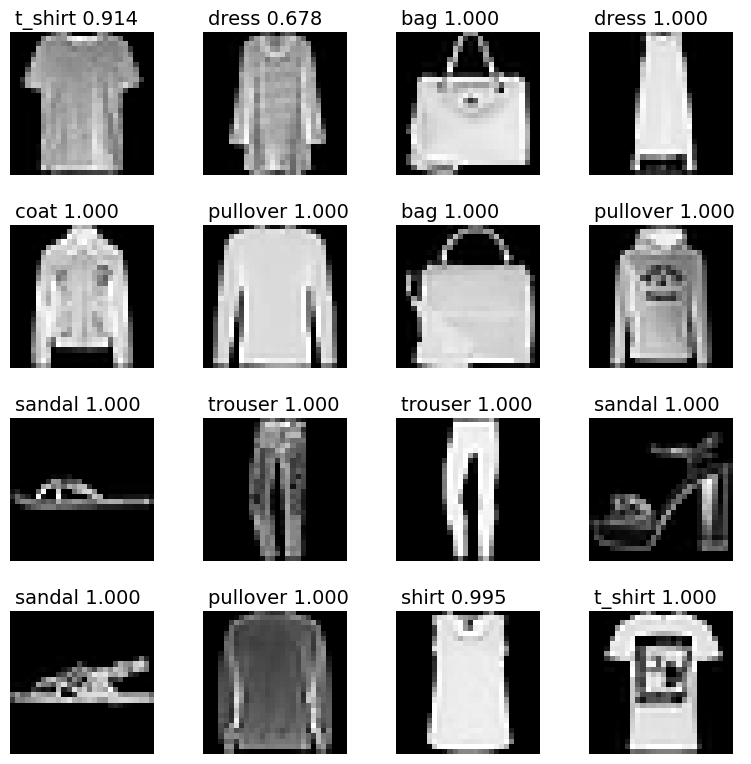

In [32]:
#model.save('trained_model2.h5')
#trained_model = load_model('trained_model1.h5')
#visualkeras.layered_view(trained_model).show()

LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')

    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i], cmap='gray')
    axes[x, y].text(0.5, -2.0, label + ' %.3f ' % confidence, fontsize=14)

  plt.gcf().set_size_inches(8, 8)
  plt.tight_layout(pad=2.0)


x_predict = np.array([x_test_conv[i] for i in random.sample(range(len(x_test_conv)), 16) ])

plot_predictions(np.squeeze(x_predict), model_conv.predict(x_predict))

plt.show()

# Plotten einiger Vorhersagen inklusive der Wahrscheinlichkeiten

1/1 [==============================] - 1s 651ms/step


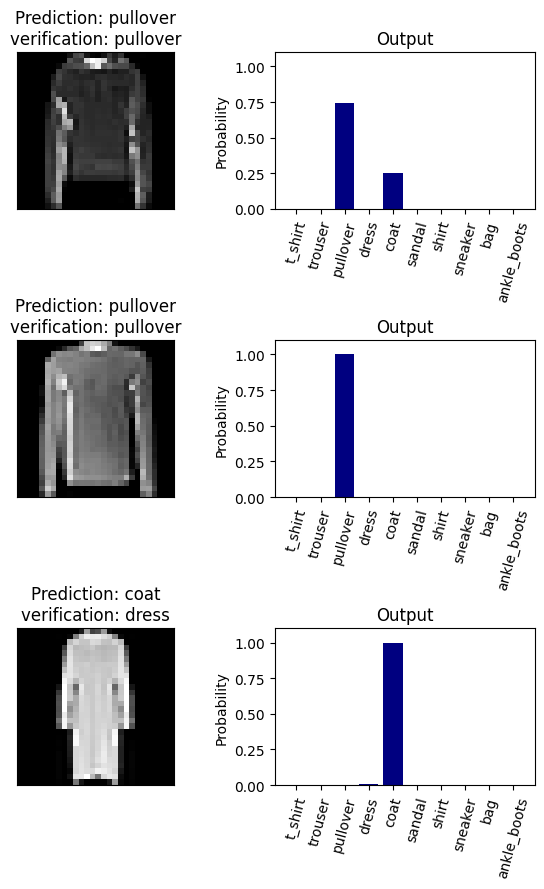

In [33]:
import random
def predictAndPlotAndShowOutput(x_predics, predictions, y_plt):

    fig, ax = plt.subplots(3, 2, figsize=(6, 9))
    for j in range(3):
        vorhersage = LABEL_NAMES[np.argmax(predictions[j])]
        confidence = np.max(predictions[j])
        ax[j, 0].imshow(x_predics[j], cmap='gray', interpolation='none')
        ax[j, 0].set_title("Prediction: "+str(vorhersage)+ "\nverification: " + LABEL_NAMES[y_plt[j]])
        ax[j, 0].axes.get_xaxis().set_visible(False)
        ax[j, 0].axes.get_yaxis().set_visible(False)
        ax[j, 1].bar(np.arange(10), predictions[j], color ='navy')
        ax[j, 1].set_ylabel("Probability")
        ax[j, 1].set_ylim(0,1.1)
        ax[j, 1].set_title("Output")
        ax[j, 1].set_xticks(np.arange(10))
        ax[j, 1].set_xticklabels(LABEL_NAMES, rotation=75)
    plt.subplots_adjust(hspace=0.8, wspace = 0.3)
    #ax[j, 2*i+1].set_xticks(np.arange(0, 10, step=1))
    plt.tight_layout()
    plt.savefig("output.png", dpi=500)

plot_samples = random.sample(range(1, len(x_test_conv) + 1), 3)
x_plt = np.array([x_test_conv[i] for i in plot_samples])
y_plt = np.array([y_test_conv[i] for i in plot_samples])

predictAndPlotAndShowOutput(np.squeeze(x_plt), model_conv.predict(x_plt), y_plt)

# Fully connected layer Modell erstellen

In [40]:
import keras as keras
import numpy as np
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from keras.models import clone_model
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
def createFullyConnectedModel():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(600, activation='relu', input_shape=(784,),name = "input_layer"))
    model.add(Dense(400, activation='relu',  name = "hidden_layer_1"))
    model.add(Dense(100, activation='relu',  name = "hidden_layer_2"))
    model.add(Dense(10, activation = 'softmax', name = "output_layer"))
    return model


# Training des Fully Connected Neural Networks mit allen Test Genauigkeiten

In [41]:
(x_train_full_connected, y_train_full_connected), (x_test_full_connected, y_test_full_connected) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train_full_connected = np.expand_dims(x_train_full_connected, -1)
x_test_full_connected = np.expand_dims(x_test_full_connected, -1)
optimizer = Adam(learning_rate=0.001)

In [42]:
modelFullyConnected = createFullyConnectedModel()
modelFullyConnected.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_losses_fully_con, train_accuracies_fully_con, test_losses_fully_con, test_accuracies_fully_con, modelFullyConnected = train_and_get_metrics(modelFullyConnected, x_train_full_connected, y_train_full_connected, x_test_full_connected, y_test_full_connected,  epochs=17,  batch_size=128)
modelFullyConnected.save('fully_connected_model.h5')
with open('LerningFullyConnected.txt', 'w') as file:
    for eintrag0, eintrag1, eintrag2, eintrag3, eintrag4 in zip(np.arange(1,18),train_losses_fully_con, train_accuracies_fully_con, test_losses_fully_con, test_accuracies_fully_con):
        file.write(f"{eintrag0} {eintrag1} {eintrag2} {eintrag3} {eintrag4}\n")

Epoch 1/17
  4/469 [..............................] - ETA: 8s - loss: 152.0573 - accuracy: 0.1777   

469/469 [==============================] - 13s 20ms/step - loss: 3.6470 - accuracy: 0.7565
Epoch 2/17
469/469 [==============================] - 9s 19ms/step - loss: 0.5117 - accuracy: 0.8339
Epoch 3/17
469/469 [==============================] - 9s 20ms/step - loss: 0.4142 - accuracy: 0.8567
Epoch 4/17
469/469 [==============================] - 10s 21ms/step - loss: 0.3657 - accuracy: 0.8712
Epoch 5/17
469/469 [==============================] - 9s 20ms/step - loss: 0.3492 - accuracy: 0.8735
Epoch 6/17
469/469 [==============================] - 9s 20ms/step - loss: 0.3246 - accuracy: 0.8826
Epoch 7/17
469/469 [==============================] - 9s 20ms/step - loss: 0.3245 - accuracy: 0.8816
Epoch 8/17
469/469 [==============================] - 9s 20ms/step - loss: 0.3123 - accuracy: 0.8862
Epoch 9/17
469/469 [==============================] - 9s 19ms/step - loss: 0.3090 - accuracy: 0.8878
Epoch 10/17
469/469 [==============================] - 9s 19ms/step - loss: 0.2952 - accuracy: 0.890

# Plotten der Ergebnisse

In [ ]:
epochs = np.arange(1,18)
plt.plot(epochs, train_losses_conv, label = 'Training Data c', color ='blue')
plt.plot(epochs, test_losses_conv, label = 'Test Data c', color ='navy')
plt.plot(epochs, train_losses_fully_con, label = 'Training Data f', color ='red')
plt.plot(epochs, test_losses_fully_con, label = 'Test Data f', color ='firebrick')

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_accuracies_conv, label = 'Training Data convolutional', color ='blue')
plt.plot(epochs, test_accuracies_conv, label = 'Test Data convolutional', color ='navy')
plt.plot(epochs, train_accuracies_fully_con, label = 'Training Data fully connected', color ='red')
plt.plot(epochs, test_accuracies_fully_con, label = 'Test Data fully connected', color ='firebrick')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plotten der Outputs aller Filter des Convolutional NN

1/1 [==============================] - 0s 262ms/step


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fb924d9d630>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, in __del__
    context.remove_function(self.name)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 2724, in remove_function
    context().remove_function(name)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 1387, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_102866'.


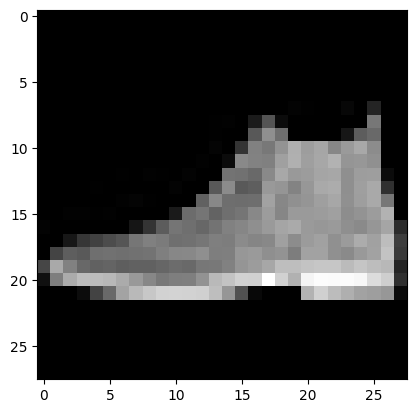

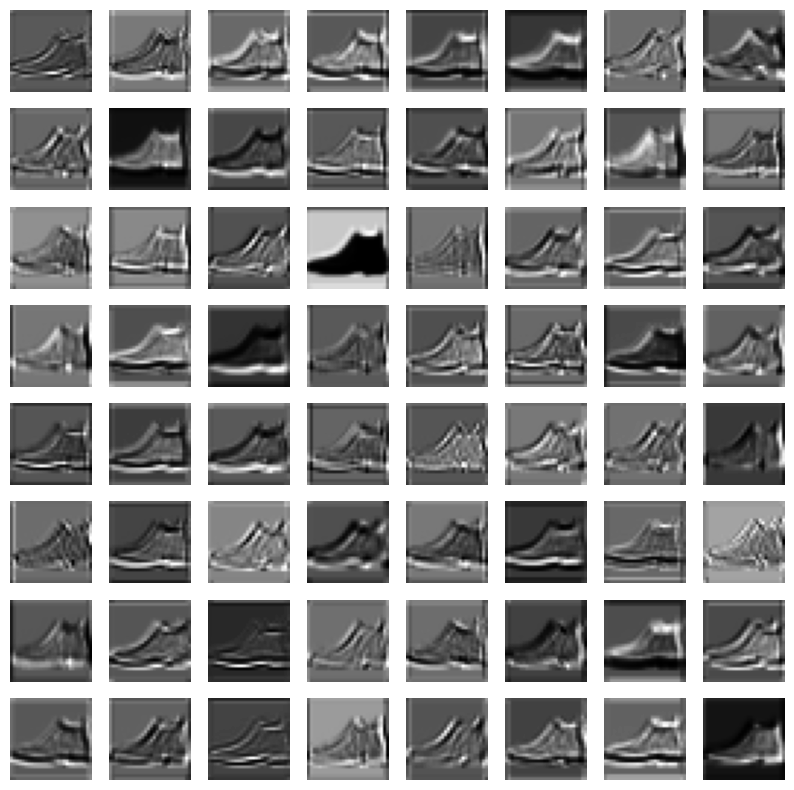

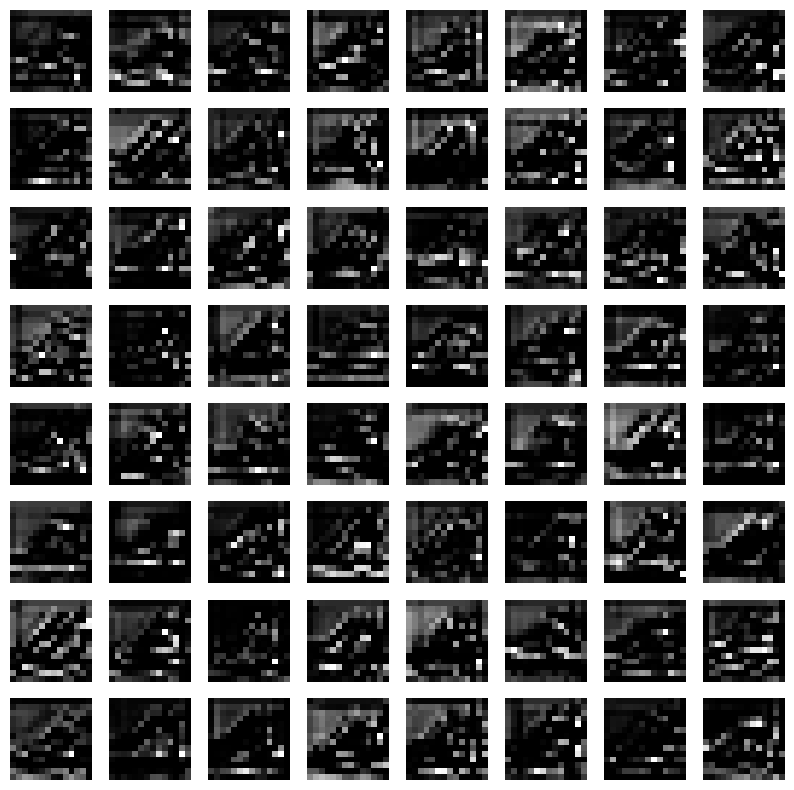

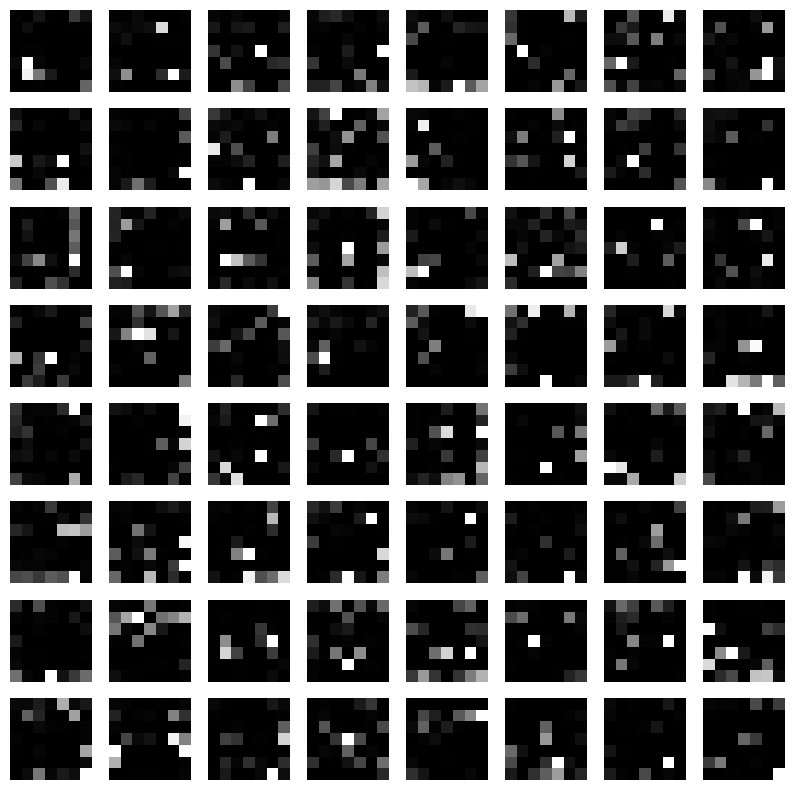

In [44]:
import matplotlib.pyplot as plt
conv_layer_indices = [0, 1, 2]
# Lade ein Testbeispiel (z.B. x_test[0])
samle_nr = 0
test_example = x_test_conv[samle_nr]

# Erstelle ein neues Modell, das die Zwischenergebnisse der ausgewählten Schichten ausgibt
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]
layer_outputs = [conv_layers[i].output for i in conv_layer_indices]
activation_model = tf.keras.models.Model(inputs=model_conv.input, outputs=layer_outputs)

# Nutze das Testbeispiel, um die Zwischenergebnisse zu erhalten
activations = activation_model.predict(np.expand_dims(test_example, axis=0))
plt.imshow(x_test_conv[samle_nr], cmap='gray')
# Plotte die Zwischenergebnisse
for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    num_filters = activation.shape[3]  # Anzahl der Filter für diesen Convolutional Layer
    num_plots = min(num_filters, 64)  # Höchstens 64 Plots
    for j in range(num_plots):
        plt.subplot(8, 8, j+1)
        plt.imshow(activation[0, :, :, j], cmap='gray')
        plt.axis('off')
    plt.show()

(5, 5, 1, 64)


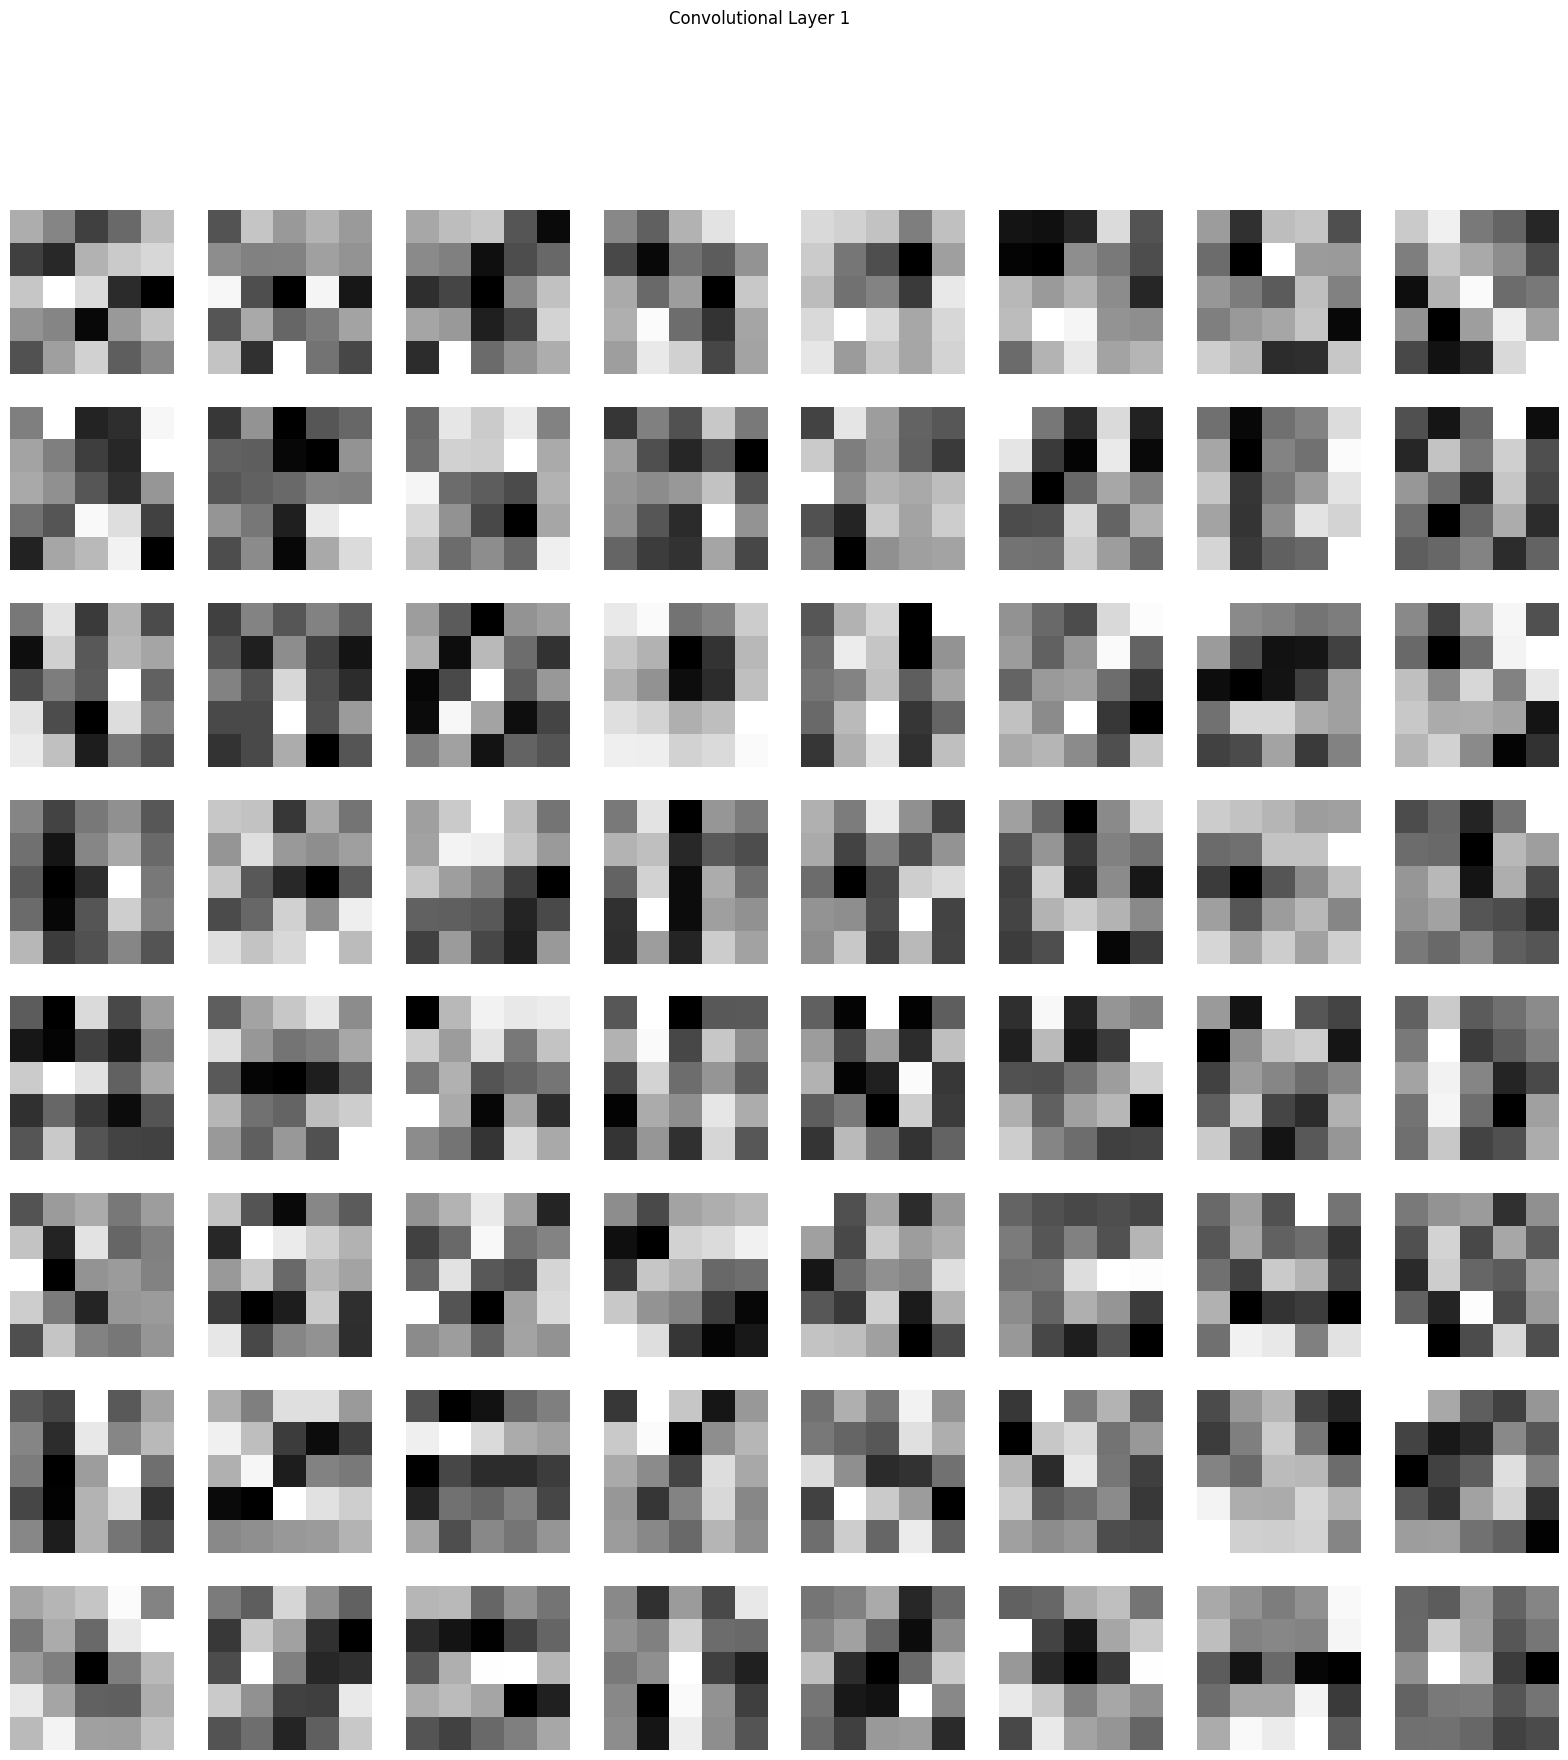

(5, 5, 64, 128)


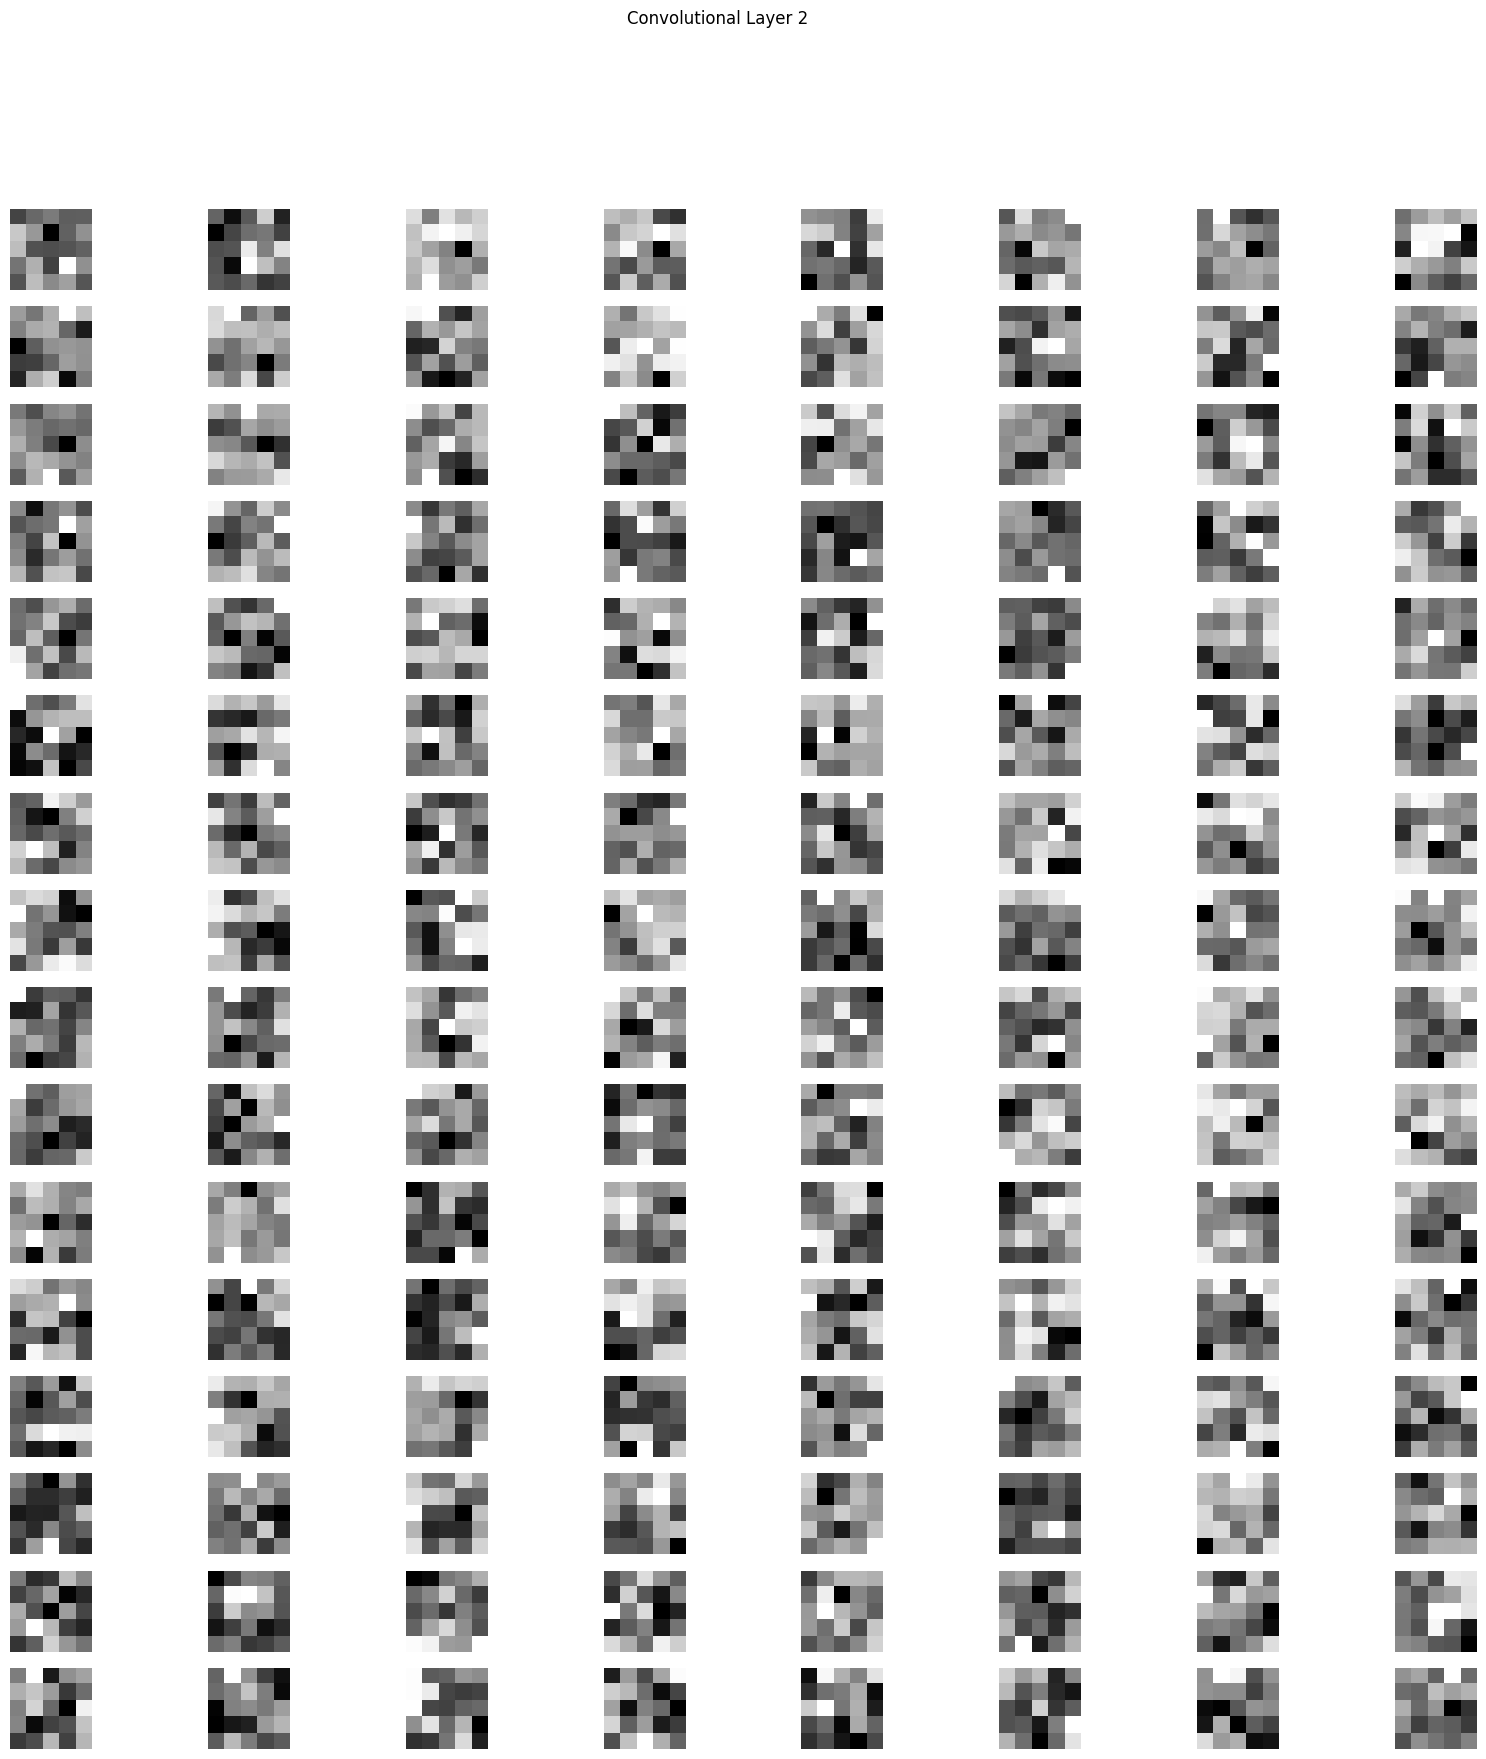

(5, 5, 128, 256)


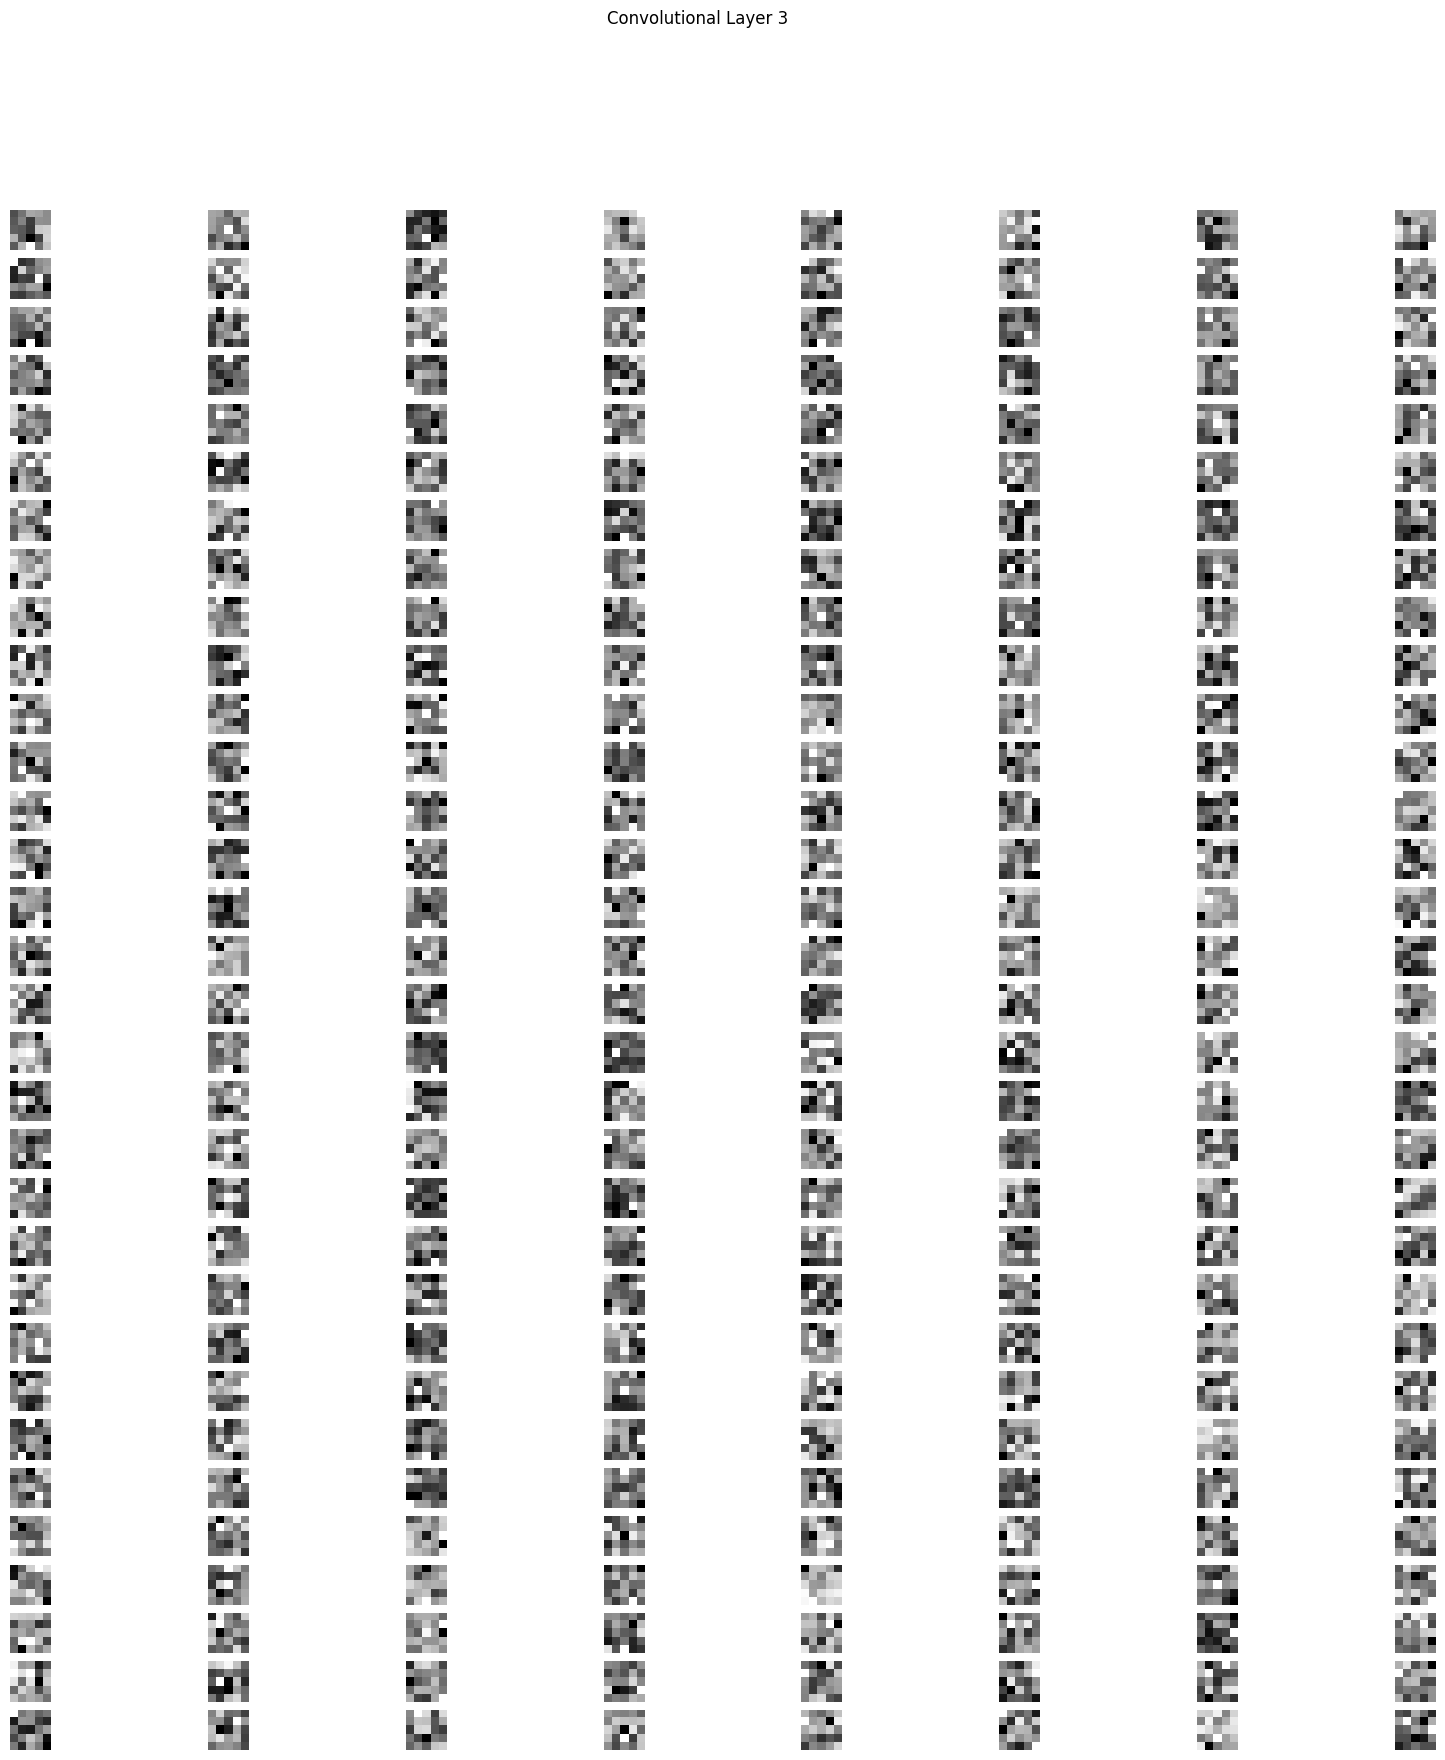

In [47]:
# Gewichtung der Konvolutionalschichten erhalten
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Filtern für jede Konvolutional-Schicht plotten
for i, layer in enumerate(conv_layers):
    weights = layer.get_weights()[0]
    print(weights.shape)

    # Anzahl der Filter in der aktuellen Schicht
    num_filters = weights.shape[3]

    # Anzahl der Subplots pro Zeile und Spalte
    n_cols = 8
    n_rows = (num_filters + n_cols - 1) // n_cols  # Rundet nach oben auf, um genügend Reihen zu haben

    plt.figure(figsize=(20, 20))
    for j in range(num_filters):
        plt.subplot(n_rows, n_cols, j + 1)
        plt.imshow(weights[:, :, 0, j], cmap='gray')  # Angenommen, Graustufenfilter
        plt.axis('off')
    plt.suptitle(f'Convolutional Layer {i+1}')
    plt.show()

# Vergleich Optimizer Adam vs SGD

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model_conv_SGD = createConvModel()
  model_conv_SGD.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, ),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
  train_losses_conv_SGD, train_accuracies_conv_SGD, test_losses_conv_SGD, test_accuracies_conv_SGD, model_conv_SGD = train_and_get_metrics(model_conv_SGD, x_train_conv, y_train_conv, x_test_conv, y_test_conv,  epochs=17,  batch_size=128)
  model_conv_SGD.save('convolutional_model_SGD.h5')

  with open('LerningConvNN.txt', 'w') as file:
      for eintrag0, eintrag1, eintrag2, eintrag3, eintrag4 in zip(np.arange(1,18),train_losses_conv_SGD, train_accuracies_conv_SGD, test_losses_conv_SGD, test_accuracies_conv_SGD):
          file.write(f"{eintrag0} {eintrag1} {eintrag2} {eintrag3} {eintrag4}\n")

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Epoch 1/17
  4/469 [..............................] - ETA: 9s - loss: 2.4305 - sparse_categorical_accuracy: 0.1543     

469/469 [==============================] - 28s 36ms/step - loss: 0.6155 - sparse_categorical_accuracy: 0.7941
Epoch 2/17
397/469 [========================>.....] - ETA: 1s - loss: 0.4258 - sparse_categorical_accuracy: 0.8544